In [1]:
import keras
from keras.models import Model, Sequential
from keras.layers import Input,Dense,LSTM,Dropout,LeakyReLU,Activation
from keras.layers import TimeDistributed,Flatten,Conv2D,Reshape,concatenate,Lambda
from keras.callbacks import ModelCheckpoint,TensorBoard
import keras.backend as K
import numpy as np
from tqdm import tqdm
import pickle as pkl
from random import sample
from time import time
import os
import pickle
import gc
import matplotlib.pyplot as plt
import sklearn
from keras.utils.vis_utils import plot_model
import itertools
from joblib import delayed, Parallel
from IPython.display import Image

Using TensorFlow backend.


#  Parameters

In [2]:
FACE_FEATURES_DIR = '../audio_target/1_face_features_min_max_scaled/'
AUDIO_FEATURES_DIR = '../audio_features/audio_features/'

In [5]:
time_delay = 50
look_back = 100

audio_frames_per_seconds = 200
video_frames_per_seconds = 20

tbCallback = TensorBoard(log_dir="logs/{}".format(time()))
# TensorBoard(log_dir='./Graph', histogram_freq=0, batch_size=n_batch, write_graph=True, write_images=True)

# Load data

In [3]:
face_features_files = os.listdir(FACE_FEATURES_DIR)
audio_features_files = os.listdir(AUDIO_FEATURES_DIR)

In [4]:
features_files = sorted(list(set(face_features_files).intersection(set(audio_features_files))))
features_files = [features_file for features_file in features_files if 'pickle' in features_file]
features_files.sort()
len(features_files)

161

In [6]:
def _load_single(fn, subsample_one_every_n):
    X, X_extra, y = [], [], []
    with open(os.path.join(AUDIO_FEATURES_DIR,fn), 'rb') as f:
        audio = pickle.load(f)
    with open(os.path.join(FACE_FEATURES_DIR,fn), 'rb') as f:
        video = pickle.load(f) # face features

    for i_start in range(0,len(audio), subsample_one_every_n):
        i_end = i_start + look_back

        if i_end > len(audio):
            continue

        i_video = int(((i_start + look_back - time_delay) / audio_frames_per_seconds) * video_frames_per_seconds)

        if i_video < 0 or i_video >= len(video):
            continue

        a = audio[i_start:i_end]
        v = video[i_video]
        if np.any(v.std(axis=0)==0):
            continue
        X.append(a)
        X_extra.append(v[:48].reshape((48*2)))
        y.append(v[48:].reshape((20*2)))
    gc.collect()
    del video, audio
    gc.collect()
    return X, X_extra, y

In [7]:
def load_multiple(fns, subsample_one_every_n):
    def _concatenate(iterables_arr):
        return list(itertools.chain(*iterables_arr))
    res = []
    
    with tqdm(fns) as tqdm_fns:
        with Parallel(n_jobs=5) as par:
            res = par(delayed(_load_single)(fn, subsample_one_every_n) for fn in tqdm_fns)
    
    X, X_extra, y = [], [], []
    
    for X1, X_extra1, Y1 in res:
        X.append(X1)
        X_extra.append(X_extra1)
        y.append(Y1)
    
    gc.collect()
    X = np.array(_concatenate(X), dtype=np.float64)
    X_extra = np.array(_concatenate(X_extra), dtype=np.float64)
    y = np.array(_concatenate(y), dtype=np.float64)
    gc.collect()
    return X, X_extra, y

In [30]:
trainX, trainX_extra, trainy = load_multiple(features_files[:140], 30)

100%|██████████| 140/140 [00:11<00:00, 12.77it/s]


In [31]:
validX, validX_extra, validy = load_multiple(features_files[140:], 200)

100%|██████████| 21/21 [00:00<00:00, 966.63it/s]


In [32]:
testX, testX_extra, testy = load_multiple(features_files[140:141], 20)

100%|██████████| 1/1 [00:00<00:00, 257.54it/s]


In [33]:
def print_shapes(X, X_extra, y, name):
    print(f'{name}X.shape\t\t',X.shape)
    print(f'{name}X_extra.shape\t',X_extra.shape)
    print(f'{name}y.shape\t\t',y.shape)
print_shapes(trainX, trainX_extra, trainy,'train')
print_shapes(validX, validX_extra, validy,'valid')
print_shapes(testX, testX_extra, testy,'test')

trainX.shape		 (134515, 100, 39)
trainX_extra.shape	 (134515, 96)
trainy.shape		 (134515, 40)
validX.shape		 (2301, 100, 39)
validX_extra.shape	 (2301, 96)
validy.shape		 (2301, 40)
testX.shape		 (1195, 100, 39)
testX_extra.shape	 (1195, 96)
testy.shape		 (1195, 40)


# Normalize Data

In [34]:
def mean_to_0(y):
    y[:,::2] -= y[:,::2].mean(axis=1, keepdims=True)
    y[:,1::2] -= y[:,1::2].mean(axis=1, keepdims=True)
    return y
trainy = mean_to_0(trainy)
validy = mean_to_0(validy)
testy  = mean_to_0(testy )

In [35]:
scalerX = sklearn.preprocessing.MinMaxScaler().fit(trainX.reshape((trainX.shape[0], -1)))
scalerX_extra = sklearn.preprocessing.MinMaxScaler().fit(trainX_extra)
scalery = sklearn.preprocessing.MinMaxScaler().fit(trainy)

In [36]:
def scale_data(X, X_extra, y):
    X = scalerX.transform(X.reshape((X.shape[0],-1))).reshape((X.shape[0], look_back, -1))
    X_extra = scalerX_extra.transform(X_extra)
    y = scalery.transform(y)
    return X, X_extra, y

In [37]:
trainX, trainX_extra, trainy = scale_data(trainX, trainX_extra, trainy)

In [38]:
validX, validX_extra, validy = scale_data(validX, validX_extra, validy)

In [39]:
testX , testX_extra , testy  = scale_data(testX , testX_extra , testy )

# Print Helper

In [18]:
def print_mouths(gt=None, pred=None):
    def print_mouth(points, color):
        if points is None:
            return
        points = scalery.inverse_transform([points])[0]
        x = points[::2]
        y = -points[1::2]
        plt.plot(x[:12],y[:12],color)
        plt.plot(x[[0,11]],y[[0,11]],color)
        plt.plot(x[[0,12]],y[[0,12]],color)
        plt.plot(x[[6,16]],y[[6,16]],color)
        plt.plot(x[[19,12]],y[[19,12]],color)
        plt.plot(x[12:20], y[12:20],color)
    print_mouth(gt,   'b')
    print_mouth(pred, 'r')
    
    custom_lines = [plt.Line2D([0], [0], color='b', lw=4),
                plt.Line2D([0], [0], color='r', lw=4)]
    plt.legend(custom_lines, ['Ground Truth', 'Prediction'])


# Combined Model

In [19]:
def create_combined_model():
    face_input =Input(shape=(48*2,),          name='face_input',  dtype='float32')
    audio_input=Input(shape=(look_back, 39,), name='audio_input', dtype='float32')
    
    # face layers:
    face=Dense(32, activation='sigmoid',               name='face_dense_1')     (face_input)    
    face=Dropout(0.4,                                  name='face_dropout_1')   (face)
    face=Dense(5,                                      name='face_dense_2')     (face)
    
    face_only_output = Dense(40, activation='sigmoid', name='face_only_output') (face)
        
    # audio layer:
    audio = TimeDistributed(
        Dense(30, activation='sigmoid',    name='audio_TD_1'))      (audio_input)
    audio = Dropout(0.2,                   name='audio_dropout_1') (audio)
    audio = LSTM(25,return_sequences=True, name='audio_lstm_1')    (audio)
    audio = Reshape((1,look_back,25),      name='audio_reshape_1') (audio)
    audio = Dropout(0.4,                   name='audio_dropout_2') (audio)
    audio = Conv2D(20, kernel_size=(25,25), strides=5, activation='sigmoid',
       data_format='channels_first',       name='audio_conv2d_1')  (audio)
    audio = Flatten(                       name='audio_flatten_1') (audio)
    audio = Dropout(0.4,                   name='audio_dropout_3') (audio)
    audio = Dense(5, activation='sigmoid', name='audio_dense_1')   (audio)
    
    audio_boosting = Dense(40, 
        activation='sigmoid',              name='audio_boosting')   (audio)
    audio_boosting = Lambda(lambda x:x*2-1,name='audio_boosting_lambda')(
                                                                    audio_boosting)
    audio_boosting_output=keras.layers.Add(name='audio_boosting_output')(
                                                                    [face_only_output, audio_boosting])
        
    #concatenate_layer:
    conc = concatenate([audio, face],      name='concatenation_1')
    conc = Dense(20, activation='sigmoid', name='conc_dense_1') (conc)
    
    conc_output = Dense(40,
        activation='sigmoid',              name='conc_output')  (conc)

    model_combined  = Model(inputs=[audio_input, face_input],
                            outputs=[face_only_output, audio_boosting_output, conc_output])
    return model_combined

model_combined = create_combined_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [20]:
model_combined.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
audio_input (InputLayer)        (None, 100, 39)      0                                            
__________________________________________________________________________________________________
time_distributed_1 (TimeDistrib (None, 100, 30)      1200        audio_input[0][0]                
__________________________________________________________________________________________________
audio_dropout_1 (Dropout)       (None, 100, 30)      0           time_distributed_1[0][0]         
__________________________________________________________________________________________________
audio_lstm_1 (LSTM)             (None, 100, 25)      5600        audio_dropout_1[0][0]            
__________________________________________________________________________________________________
audio_resh

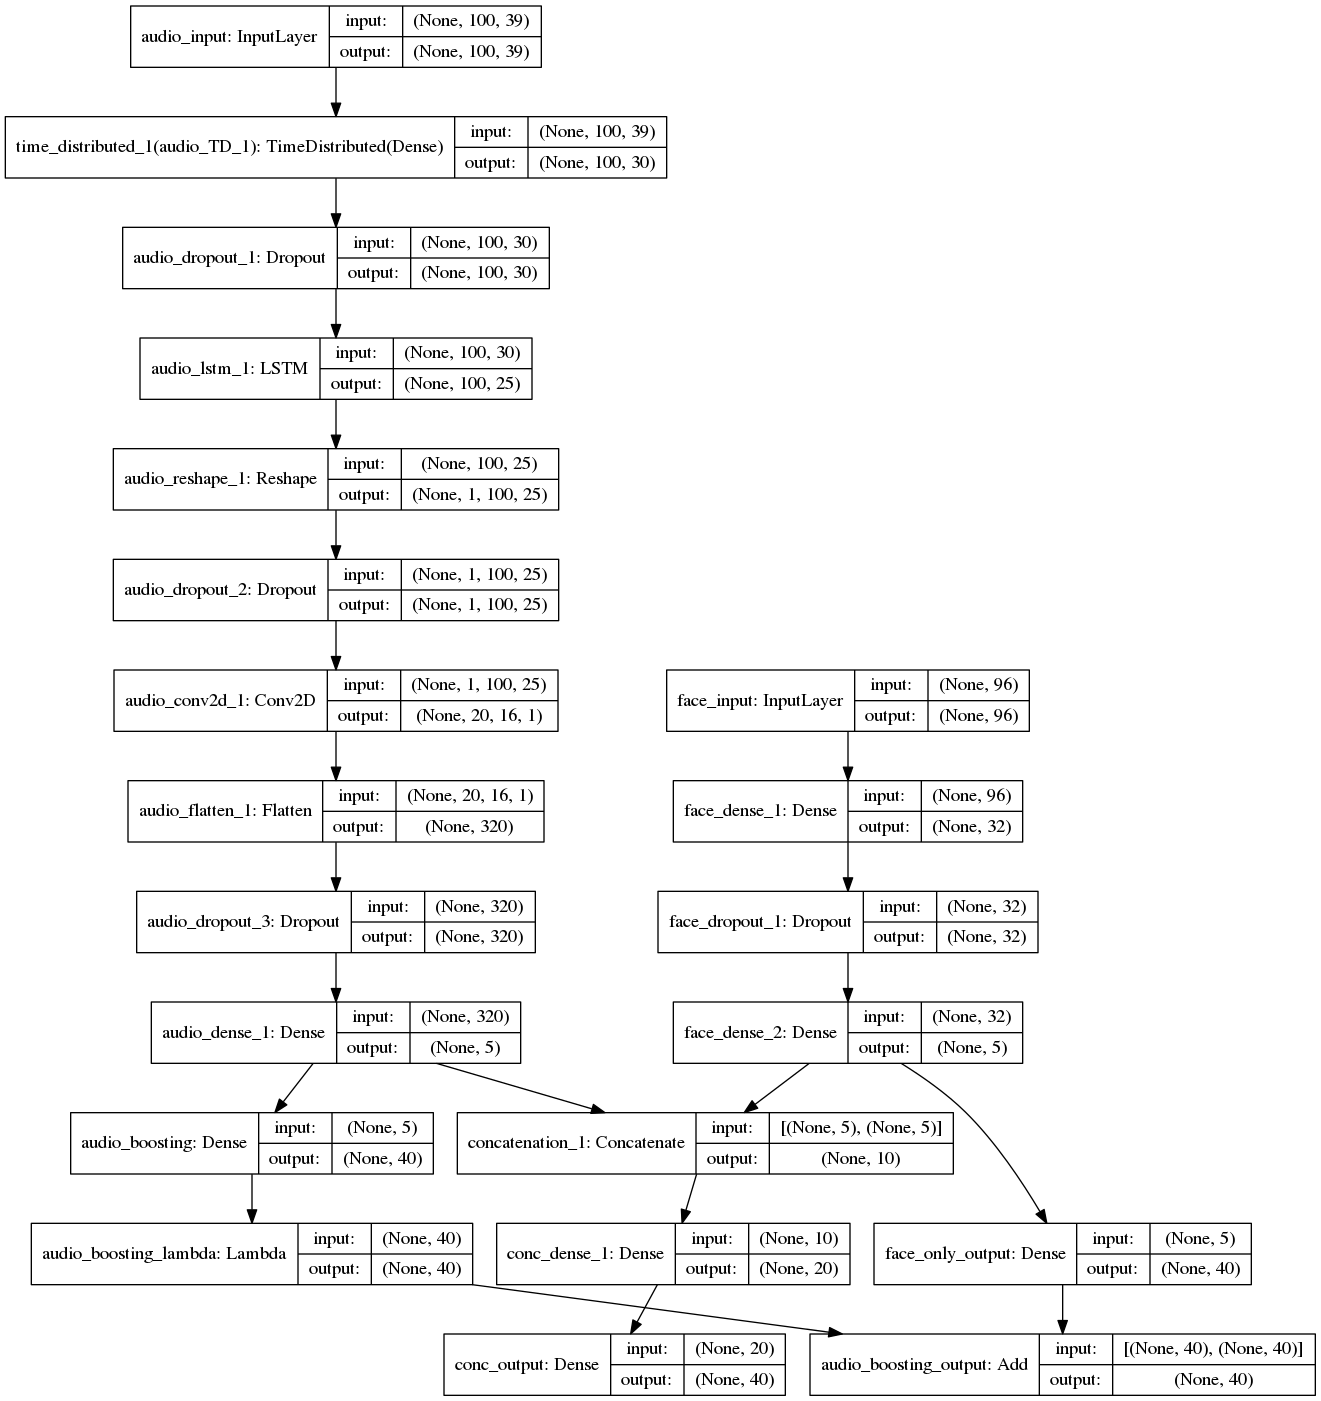

In [21]:
plot_model(model_combined, to_file='model_combined_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='model_combined_plot.png')

#  Training

In [22]:
model_combined.compile(optimizer='rmsprop', 
                       loss={'face_only_output':'mae', 'audio_boosting_output':'mae', 'conc_output':'mae'},
                       loss_weights={'face_only_output':.1, 'audio_boosting_output':.2, 'conc_output':.7})
history = model_combined.fit({'audio_input': trainX, 'face_input': trainX_extra}, 
                             {'face_only_output':trainy, 'audio_boosting_output':trainy, 'conc_output':trainy},
    epochs = 200, batch_size = 256, verbose = 1, shuffle = True,
        callbacks = [ModelCheckpoint('checkpoint_combined_model.h5'),
           ModelCheckpoint('checkpoint_combined_model_best_1.h5', save_best_only=True, 
                           monitor='val_conc_output_loss')],
             validation_data=({'audio_input': validX, 'face_input': validX_extra},
               {'face_only_output':validy, 'audio_boosting_output':validy, 'conc_output':validy}))

Instructions for updating:
Use tf.cast instead.
Train on 53839 samples, validate on 2301 samples
Epoch 1/200
53839/53839 [==============================] - 34s 622us/step - loss: 0.0846 - face_only_output_loss: 0.0875 - audio_boosting_output_loss: 0.0828 - conc_output_loss: 0.0846 - val_loss: 0.0620 - val_face_only_output_loss: 0.0651 - val_audio_boosting_output_loss: 0.0618 - val_conc_output_loss: 0.0617
Epoch 2/200
53839/53839 [==============================] - 32s 595us/step - loss: 0.0618 - face_only_output_loss: 0.0649 - audio_boosting_output_loss: 0.0628 - conc_output_loss: 0.0610 - val_loss: 0.0547 - val_face_only_output_loss: 0.0553 - val_audio_boosting_output_loss: 0.0550 - val_conc_output_loss: 0.0546
Epoch 3/200
53839/53839 [==============================] - 32s 586us/step - loss: 0.0558 - face_only_output_loss: 0.0590 - audio_boosting_output_loss: 0.0585 - conc_output_loss: 0.0546 - val_loss: 0.0493 - val_face_only_output_loss: 0.0521 - val_audio_boosting_output_loss: 0.052

53839/53839 [==============================] - 31s 581us/step - loss: 0.0414 - face_only_output_loss: 0.0476 - audio_boosting_output_loss: 0.0445 - conc_output_loss: 0.0396 - val_loss: 0.0368 - val_face_only_output_loss: 0.0418 - val_audio_boosting_output_loss: 0.0387 - val_conc_output_loss: 0.0355
Epoch 53/200
53839/53839 [==============================] - 32s 586us/step - loss: 0.0414 - face_only_output_loss: 0.0476 - audio_boosting_output_loss: 0.0444 - conc_output_loss: 0.0396 - val_loss: 0.0365 - val_face_only_output_loss: 0.0417 - val_audio_boosting_output_loss: 0.0384 - val_conc_output_loss: 0.0352
Epoch 54/200
53839/53839 [==============================] - 31s 583us/step - loss: 0.0412 - face_only_output_loss: 0.0476 - audio_boosting_output_loss: 0.0444 - conc_output_loss: 0.0394 - val_loss: 0.0380 - val_face_only_output_loss: 0.0417 - val_audio_boosting_output_loss: 0.0394 - val_conc_output_loss: 0.0370
Epoch 55/200
53839/53839 [==============================] - 33s 611us/step

53839/53839 [==============================] - 33s 607us/step - loss: 0.0397 - face_only_output_loss: 0.0473 - audio_boosting_output_loss: 0.0435 - conc_output_loss: 0.0376 - val_loss: 0.0358 - val_face_only_output_loss: 0.0416 - val_audio_boosting_output_loss: 0.0380 - val_conc_output_loss: 0.0343
Epoch 105/200
53839/53839 [==============================] - 31s 584us/step - loss: 0.0397 - face_only_output_loss: 0.0473 - audio_boosting_output_loss: 0.0434 - conc_output_loss: 0.0376 - val_loss: 0.0353 - val_face_only_output_loss: 0.0411 - val_audio_boosting_output_loss: 0.0372 - val_conc_output_loss: 0.0339
Epoch 106/200
53839/53839 [==============================] - 31s 583us/step - loss: 0.0398 - face_only_output_loss: 0.0474 - audio_boosting_output_loss: 0.0435 - conc_output_loss: 0.0377 - val_loss: 0.0356 - val_face_only_output_loss: 0.0416 - val_audio_boosting_output_loss: 0.0379 - val_conc_output_loss: 0.0341
Epoch 107/200
53839/53839 [==============================] - 31s 579us/s

53839/53839 [==============================] - 32s 590us/step - loss: 0.0390 - face_only_output_loss: 0.0473 - audio_boosting_output_loss: 0.0431 - conc_output_loss: 0.0367 - val_loss: 0.0354 - val_face_only_output_loss: 0.0412 - val_audio_boosting_output_loss: 0.0375 - val_conc_output_loss: 0.0340
Epoch 157/200
53839/53839 [==============================] - 31s 585us/step - loss: 0.0391 - face_only_output_loss: 0.0474 - audio_boosting_output_loss: 0.0432 - conc_output_loss: 0.0368 - val_loss: 0.0353 - val_face_only_output_loss: 0.0414 - val_audio_boosting_output_loss: 0.0375 - val_conc_output_loss: 0.0338
Epoch 158/200
53839/53839 [==============================] - 31s 581us/step - loss: 0.0391 - face_only_output_loss: 0.0474 - audio_boosting_output_loss: 0.0432 - conc_output_loss: 0.0367 - val_loss: 0.0351 - val_face_only_output_loss: 0.0415 - val_audio_boosting_output_loss: 0.0374 - val_conc_output_loss: 0.0336
Epoch 159/200
53839/53839 [==============================] - 31s 583us/s

In [142]:
model_combined.compile(optimizer='adam', 
                       loss={'face_only_output':'mae', 
                             'audio_boosting_output':'mae', 
                             'conc_output':'mae'},
                       loss_weights={'face_only_output':.01, 'audio_boosting_output':.01, 'conc_output':.98})
history2 = model_combined.fit({'audio_input': trainX, 'face_input': trainX_extra}, 
                             {'face_only_output':trainy, 'audio_boosting_output':trainy, 'conc_output':trainy},
    epochs = 200, batch_size = 4096, verbose = 1, shuffle = True,
        callbacks = [ModelCheckpoint('checkpoint_combined_model.h5'),
           ModelCheckpoint('checkpoint_combined_model_best_6_RMSE.h5', save_best_only=True, 
                           monitor='val_conc_output_loss')],
             validation_data=({'audio_input': validX, 'face_input': validX_extra},
               {'face_only_output':validy, 'audio_boosting_output':validy, 'conc_output':validy}))

Train on 134515 samples, validate on 2301 samples
Epoch 1/200
134515/134515 [==============================] - 18s 130us/step - loss: 0.0336 - face_only_output_loss: 0.0506 - audio_boosting_output_loss: 0.0463 - conc_output_loss: 0.0333 - val_loss: 0.0311 - val_face_only_output_loss: 0.0459 - val_audio_boosting_output_loss: 0.0416 - val_conc_output_loss: 0.0308
Epoch 2/200
134515/134515 [==============================] - 12s 91us/step - loss: 0.0336 - face_only_output_loss: 0.0506 - audio_boosting_output_loss: 0.0462 - conc_output_loss: 0.0333 - val_loss: 0.0310 - val_face_only_output_loss: 0.0462 - val_audio_boosting_output_loss: 0.0417 - val_conc_output_loss: 0.0308
Epoch 3/200
134515/134515 [==============================] - 12s 90us/step - loss: 0.0335 - face_only_output_loss: 0.0506 - audio_boosting_output_loss: 0.0462 - conc_output_loss: 0.0332 - val_loss: 0.0310 - val_face_only_output_loss: 0.0461 - val_audio_boosting_output_loss: 0.0417 - val_conc_output_loss: 0.0308
Epoch 4/20

KeyboardInterrupt: 

In [144]:
def get_valid_mae():
    x = model_combined.predict({'audio_input': validX, 'face_input': validX_extra})[2]
    x = x - validy
    x = np.abs(x)
    return np.mean(x)
get_valid_mae()

0.030769535073725145

In [146]:
test_pred = model_combined.predict({'audio_input': testX, 'face_input': testX_extra})[2]

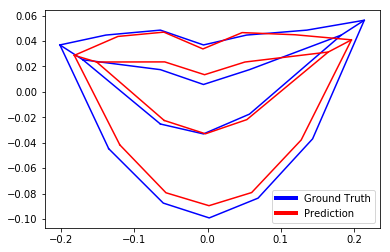

In [196]:
index_to_print = 637
print_mouths(pred=test_pred[index_to_print], gt=testy[index_to_print])

In [197]:
with open('test_pred_combined_mae_308', 'wb') as f:
    pickle.dump(scalery.inverse_transform(test_pred).reshape((-1,20,2)), f)
with open('test_gt', 'wb') as f:
    pickle.dump(scalery.inverse_transform(testy).reshape((-1,20,2)), f)

# This is code for the old models!

# 

# 

# 

# 

# 

# Face Rotation Model

In [12]:
def create_face_rotation_model():
    return Sequential([
        Dense(32, input_shape=(96,), name='face_rot_dense_1'),
        Activation('relu', name='face_rot_relu_1'),
        Dropout(0.4, name='face_rot_dropout_1'),
        Dense(5, name='face_rot_dense_2'),
        Dense(40, name='face_rot_output'),
    ])
model_face = create_face_rotation_model()
model_face.compile(optimizer='rmsprop', loss='mae')
plot_model(model_face, to_file='model_face_plot.png', show_shapes=True, show_layer_names=True)
model_face.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
face_rot_dense_1 (Dense)     (None, 32)                3104      
_________________________________________________________________
face_rot_relu_1 (Activation) (None, 32)                0         
_________________________________________________________________
face_rot_dropout_1 (Dropout) (None, 32)                0         
_________________________________________________________________
face_rot_dense_2 (Dense)     (None, 5)                 165       
_________________________________________________________________
face_rot_output (Dense)      (None, 40)                240       
Total params: 3,509
Trainable params: 3,509
Non-trainable params: 0
___________________

In [200]:
history = model_face.fit(trainX_extra,trainy,
            epochs = 20, batch_size = 16,
              verbose = 1, shuffle = True, callbacks = [ModelCheckpoint('checkpoint_face_model.h5')],
                validation_data=(validX_extra, validy))

Train on 20239 samples, validate on 2301 samples
Epoch 1/20
20239/20239 [==============================] - 3s 168us/step - loss: 0.0599 - val_loss: 0.0518
Epoch 2/20
20239/20239 [==============================] - 3s 168us/step - loss: 0.0600 - val_loss: 0.0516
Epoch 3/20
20239/20239 [==============================] - 3s 170us/step - loss: 0.0598 - val_loss: 0.0513
Epoch 4/20
20239/20239 [==============================] - 4s 176us/step - loss: 0.0597 - val_loss: 0.0500
Epoch 5/20
20239/20239 [==============================] - 3s 172us/step - loss: 0.0599 - val_loss: 0.0515
Epoch 6/20
20239/20239 [==============================] - 4s 173us/step - loss: 0.0595 - val_loss: 0.0509
Epoch 7/20
20239/20239 [==============================] - 4s 177us/step - loss: 0.0596 - val_loss: 0.0496
Epoch 8/20
20239/20239 [==============================] - 4s 174us/step - loss: 0.0595 - val_loss: 0.0488
Epoch 9/20
20239/20239 [==============================] - 4s 176us/step - loss: 0.0596 - val_loss: 0.04

In [160]:
test_pred = model_face.predict(testX_extra)

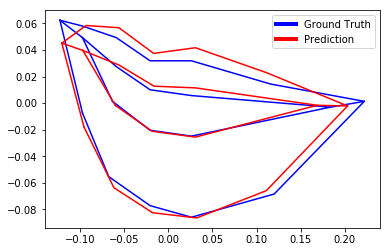

In [161]:
index_to_print = 225
print_mouths(pred=test_pred[index_to_print], gt=testy[index_to_print])

# Boosting Dataset

In [162]:
def get_remains(X_extra, y):
    return y - model_face.predict(X_extra)

In [163]:
trainy_remain = get_remains(trainX_extra, trainy)
validy_remain = get_remains(validX_extra, validy)
testy_remain  = get_remains(testX_extra , testy )

# Boosting Model

In [13]:
def create_boosting_model():
    return Sequential([
        TimeDistributed(Dense(100, name='boosting_dense_TD_1'), input_shape=(look_back, 39), name='boosting_TD_1'),
        TimeDistributed(Dense(5, name='boosting_dense_TD_2'), name='boosting_TD_2'),
        Flatten(name='boosting_flatten'),
        Dropout(0.2, name='boosting_dropout_1'),
        Dense(5, name='boosting_dense_1'),
        Activation('sigmoid', name='boosting_activation_1'),
        Dense(40, name='boosting_dense_2')
    ])
model_boost = create_boosting_model()
model_boost.compile(optimizer='adam', loss='mae')
plot_model(model_boost, to_file='model_boost_plot.png', show_shapes=True, show_layer_names=True)
model_boost.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
boosting_TD_1 (TimeDistribut (None, 100, 100)          4000      
_________________________________________________________________
boosting_TD_2 (TimeDistribut (None, 100, 5)            505       
_________________________________________________________________
boosting_flatten (Flatten)   (None, 500)               0         
_________________________________________________________________
boosting_dropout_1 (Dropout) (None, 500)               0         
_________________________________________________________________
boosting_dense_1 (Dense)     (None, 5)                 2505      
_________________________________________________________________
boosting_activation_1 (Activ (None, 5)                 0         
_________________________________________________________________
boosting_dense_2 (Dense)     (None, 40)                240       
Total para

In [173]:
history = model_boost.fit(trainX,trainy_remain,
            epochs = 100, batch_size = 32,
              verbose = 1, shuffle = False, callbacks = [ModelCheckpoint('checkpoint_boosting_model.h5')],
                validation_data=(validX, validy_remain))

Train on 20239 samples, validate on 2301 samples
Epoch 1/100
20239/20239 [==============================] - 3s 126us/step - loss: 0.0461 - val_loss: 0.0473
Epoch 2/100
20239/20239 [==============================] - 3s 127us/step - loss: 0.0459 - val_loss: 0.0470
Epoch 3/100
20239/20239 [==============================] - 3s 128us/step - loss: 0.0459 - val_loss: 0.0470
Epoch 4/100
20239/20239 [==============================] - 3s 127us/step - loss: 0.0459 - val_loss: 0.0468
Epoch 5/100
20239/20239 [==============================] - 3s 128us/step - loss: 0.0460 - val_loss: 0.0471
Epoch 6/100
20239/20239 [==============================] - 3s 128us/step - loss: 0.0460 - val_loss: 0.0468
Epoch 7/100
20239/20239 [==============================] - 3s 128us/step - loss: 0.0460 - val_loss: 0.0469
Epoch 8/100
20239/20239 [==============================] - 3s 128us/step - loss: 0.0461 - val_loss: 0.0468
Epoch 9/100
20239/20239 [==============================] - 3s 128us/step - loss: 0.0461 - val_l

KeyboardInterrupt: 

In [205]:
test_pred = model_face.predict(testX_extra) + model_boost.predict(testX)

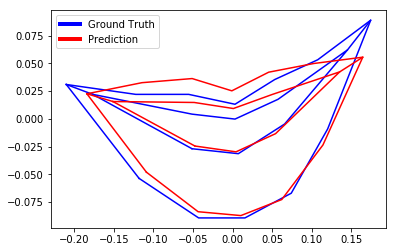

In [206]:
index_to_print = 245
print_mouths(pred=test_pred[index_to_print], gt=testy[index_to_print])

In [207]:
with open('pred_with_boosting', 'wb') as f:
    pickle.dump(scalery.inverse_transform(test_pred).reshape((test_pred.shape[0], -1, 2)), f)

In [204]:
with open('gt', 'wb') as f:
    pickle.dump(scalery.inverse_transform(testy).reshape((testy.shape[0], -1, 2)), f)

# Loss

In [249]:
def mouth_opening_loss(y_true, y_pred):
#     def get_mouth_opening_distances(y):
#         y = y[1::2]
#         return y[13:16] - y[19:16:-1]
    def mse(y_true, y_pred):
        return K.mean(K.square(y_true-y_pred))
    loss_mse = mse(y_true, y_pred)
    loss_custom = mse(y_true[13:20],y_pred[13:20])
    return 40*loss_custom + loss_mse

# Model

In [194]:
keras.backend.clear_session()
main_input = Input(shape=(look_back, 39,), dtype='float32', name='main_input')
lstm_out = LSTM(25, input_shape = (look_back, 39))(main_input)
lstm_out_do = Dropout(0.25)(lstm_out)

face_inpput = Input(shape=(48*2,), dtype='float32', name='face_input')
conc_layer = keras.layers.concatenate([lstm_out_do, face_inpput])
dense_layer = Dropout(0.25)(LeakyReLU(alpha=0.05)(Dense(100)(conc_layer)))
dense_layer = Dropout(0.25)(LeakyReLU(alpha=0.05)(Dense(100)(dense_layer)))
dense_layer = Dense(40)(dense_layer)

model = Model(inputs=[main_input, face_inpput], outputs=dense_layer)

In [250]:
# model.load_weights('checkpoint.h5')
model.compile(optimizer='rmsprop', 
              loss=mouth_opening_loss, 
              metrics=['accuracy'])
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 50, 39)       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 25)           6500        main_input[0][0]                 
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 25)           0           lstm_1[0][0]                     
__________________________________________________________________________________________________
face_input (InputLayer)         (None, 96)           0                                            
__________________________________________________________________________________________________
concatenat

In [15]:
filepath="checkpoint.h5"

# checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
checkpoint = ModelCheckpoint(filepath)
tbCallback = [checkpoint]

In [196]:
def mean_to_0(y):
    y[:,::2] -= y[:,::2].mean(axis=1, keepdims=True)
    y[:,1::2] -= y[:,1::2].mean(axis=1, keepdims=True)
    return y

In [197]:
trainy = mean_to_0(trainy)

In [278]:
testy = mean_to_0(testy)

In [18]:
# def run_epoch(trainX, trainX_extra, trainy,
#               valX,   valX_extra,   valy,
#               testX,  testX_extra,  testy, 
#               epochs = 1, batch_size = 1,
#                   verbose = 100, shuffle = True, callbacks = tbCallback):
    
#         model.fit({'main_input':trainX, 'face_input':trainX_extra},trainy,
#                     epochs = epochs, batch_size = batch_size,
#                     verbose = verbose, shuffle = shuffle, callbacks = callbacks, 
#                     validation_data = ({'main_input':valX, 'face_input':valX_extra},valy))
        
#         test_error = np.mean(np.square(testy - model.predict({'main_input':testX, 'face_input':testX_extra})))
#         print('Test Error: ', test_error)

In [198]:
scalerX = sklearn.preprocessing.MinMaxScaler()
scalerX_extra = sklearn.preprocessing.MinMaxScaler()
scalery = sklearn.preprocessing.MinMaxScaler()

In [199]:
scalerX.fit(trainX.reshape((trainX.shape[0],-1)))
scalerX_extra.fit(trainX_extra)
scalery.fit(trainy)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [200]:
trainX = scalerX.transform(trainX.reshape((-1,50*39))).reshape((-1,50,39))
trainX_extra = scalerX_extra.transform(trainX_extra)
trainy = scalery.transform(trainy)

In [279]:
testX = scalerX.transform(testX.reshape((testX.shape[0], -1))).reshape((-1,50,39))
testX_extra = scalerX_extra.transform(testX_extra)
testy = scalery.transform(testy)

In [91]:
trainX.shape

(20239, 50, 39)

In [251]:
history = model.fit({'main_input':trainX, 'face_input':trainX_extra},trainy,
            epochs = 100, batch_size = 201,
              verbose = 1, shuffle = True, callbacks = tbCallback)

Epoch 1/100
20239/20239 [==============================] - 8s 391us/step - loss: 0.2592 - acc: 0.2900
Epoch 2/100
20239/20239 [==============================] - 7s 341us/step - loss: 0.2527 - acc: 0.2916
Epoch 3/100
20239/20239 [==============================] - 7s 346us/step - loss: 0.2354 - acc: 0.2988
Epoch 4/100
20239/20239 [==============================] - 7s 350us/step - loss: 0.2214 - acc: 0.3114
Epoch 5/100
20239/20239 [==============================] - 7s 349us/step - loss: 0.2190 - acc: 0.3195
Epoch 6/100
20239/20239 [==============================] - 7s 351us/step - loss: 0.2160 - acc: 0.3192
Epoch 7/100
20239/20239 [==============================] - 7s 352us/step - loss: 0.2129 - acc: 0.3320
Epoch 8/100
20239/20239 [==============================] - 7s 354us/step - loss: 0.2287 - acc: 0.3277
Epoch 9/100
 4221/20239 [=====>........................] - ETA: 5s - loss: 0.1938 - acc: 0.3352

KeyboardInterrupt: 

In [32]:
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

NameError: name 'history' is not defined

In [280]:
test_pred = model.predict({'main_input':testX, 'face_input':testX_extra})

In [281]:
err = test_pred-testy
err = np.mean(np.square(err), axis=1)

In [282]:
np.mean(err)

0.004443956232462654

In [43]:
min_ind = np.argmax(err)

In [40]:
print(np.max(err))

0.0015492171137978076


In [102]:
with open('testY_pred', 'wb') as f:
    pickle.dump(test_pred, f)

In [104]:
features_files[140:141]

['0205.mp4.pickle']

In [46]:
features_files[140]

'0205.mp4.pickle'

Text(0.5, 1.0, 'blue-GT, red-Pred, Mouth is too open')

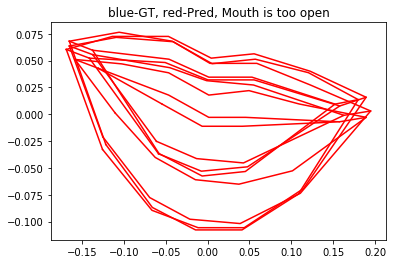

In [308]:
min_ind = 30
def print_line(points, color='b'):
    points = scalery.inverse_transform([points])[0]
    x = points[::2]
    y = -points[1::2]
    plt.plot(x[:12],y[:12],color)
    plt.plot(x[[0,11]],y[[0,11]],color)
    plt.plot(x[[0,12]],y[[0,12]],color)
    plt.plot(x[[6,16]],y[[6,16]],color)
    plt.plot(x[[19,12]],y[[19,12]],color)
    plt.plot(x[12:20], y[12:20],color)
# print_line(testy[min_ind])
print_line(test_pred[min_ind],'r')
print_line(test_pred[min_ind+1],'r')
print_line(test_pred[min_ind+2],'r')
print_line(test_pred[min_ind+3],'r')
plt.title('blue-GT, red-Pred, Mouth is too open')

In [ ]:
with open('train_pred.pickle','wb') as f:
    pickle.dump(train_pred, f)

In [ ]:
with tqdm(list(range(n_epoch))) as tqdm_epochs:
    for i in tqdm_epochs:
        X, X_extra, y = get_random_data(2)
        
        split1 = int(0.8*len(X))
        split2 = int(0.9*len(X))

        trainX = X[0:      split1]
        valX   = X[split1: split2]
        testX  = X[split2:       ]
        
        trainX_extra = X_extra[0:      split1]
        valX_extra   = X_extra[split1: split2]
        testX_extra  = X_extra[split2:       ]
        
        trainy = y[0:      split1]
        valy   = y[split1: split2]
        testy  = y[split2:       ]
        
        run_epoch(trainX, trainX_extra, trainy,
              valX,   valX_extra,   valy,
              testX,  testX_extra,  testy)

In [47]:
keras.utils.vis_utils.plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)